# Generation of "Similar" Sentences Using The Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [ ]:
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer
from keras.layers import Activation, Dropout
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import objectives

from keras.models import Model

from keras import backend as K
from keras.utils import plot_model

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

## Data

### Overview

Originally we were using a dataset of quora questions.
However, it became immediately clear that the model was
learning a single sentence which could minimize the loss
function. So, we are trying another dataset which
consists of Wikipedia sentences. It is worth noting that
this dataset has not been vetted. It is also known that
wikipedia articles contain some level of noise.

The dataset consists of roughly 800,000 questions
posted on Quora. This data was made publicly
available via Kaggle at this 
[link](https://www.kaggle.com/quora/question-pairs-dataset).
The original intent of this dataset was to find 
duplicate questions, but it works well for our 
purposes.

### Download

There are multiple ways to download the data. My
preference is to use the kaggle API.

Start by searching for the dataset

```
kaggle datasets list -s quora
```

Once you find the dataset, download it with

```
kaggle datasets download quora/question-pairs-dataset
```

This downloads a zip file. I'm working on 
Ubuntu, so I can unzip with

```
unzip question-pairs-dataset.zip
```

### Preprocess

There is a fair bit of work to be done to preprocess the data. 

In [2]:
project_path = r'/home/das-hund/PycharmProjects/autoencoders'
data_path = os.path.join(project_path, 'data')
sentences_path = os.path.join(data_path, 'wikisent2.txt')

with open(sentences_path, 'r') as wiki_sentence_file:
    sentences = wiki_sentence_file.read().split('\n')
    
sentences[0:10]

['0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.',
 '000webhost is a free web hosting service, operated by Hostinger.',
 '0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.',
 '0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.',
 '0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.',
 '001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.',
 '003230 is a South Korean food manufacturer.',
 '0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.',
 '0.04% of the votes were invalid.',
 '005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-h

### Tokenize

We will split the texts by new lines. 
This gives us a record for each question. Then
we fit a tokenizer on our texts, mapping words
to integers.

We aren't limiting the number of words, yet. 
We will see how the model performs, in the 
near future. In addition, I'm not going to
limit sequence lengths, yet. I want to see
how long the sequences are.

#### Sentence Analytics

The easiest way to do any analysis on the 
sentences is to first fit the tokenizer on
them. 

With a bit of analysis, we can see that most
sequences have fewer than 50 words. 

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [4]:
word_count = len(word_to_index)
print(f'[+] Word Count: {word_count}')

[+] Word Count: 1526234


In [6]:
MAX_WORDS = 20000 
MAX_SEQ_LEN = 50 

tokenizer.num_words = MAX_WORDS
sequences = tokenizer.texts_to_sequences(sentences)

[[6, 5, 480, 1140, 4444, 236, 620, 9], [6, 5, 758, 26, 439, 148, 793, 3, 660, 721], [1058, 1058, 74, 133, 6, 14, 4254, 3985, 4624, 275, 366, 3, 286, 17, 1981, 374, 2904, 293, 533, 983, 69, 10, 255, 9, 1, 48, 491, 10, 4254, 3985, 4, 19473, 2945, 6249, 3, 130, 430], [1058, 7978, 6, 1, 323, 234, 40, 2, 43, 10, 180, 292, 423, 9, 839, 206], [2, 133, 180, 466, 23, 8, 846, 81, 1, 192, 2, 1, 603, 2, 6434, 4], [6, 5, 55, 1354, 882, 2027], [1058, 9242, 1644, 5707, 3, 2698, 20, 3, 4183, 6306, 2067, 532, 7, 1, 14922, 1240, 2, 9391, 112, 6, 24, 9340, 81, 5707, 5, 5107, 3605], [1058, 9242, 2, 1, 2038, 34, 15386], [407, 8935, 6, 1, 839, 234, 40, 9, 1, 55, 1354, 349, 4, 658, 9763]]
[+] Max Sequence Length: 50
[+] Word Count: 1526234


(array([  56071., 1114504., 2048662., 1837118., 1262331.,  733341.,
         395200.,  204563.,  104114.,   60261.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

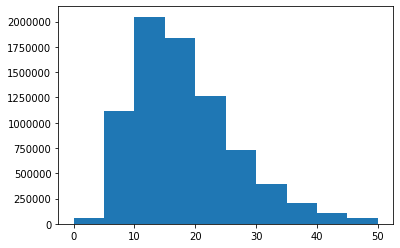

In [7]:
print(sequences[1:10])

sequence_lengths = []
for sequence in sequences:
    seq_len = len(sequence)
    if seq_len <= 50:
        sequence_lengths.append(seq_len)
sequence_lengths = np.array(sequence_lengths)
        
max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

%matplotlib inline
plt.hist(sequence_lengths)

In [8]:
# Shuffle the data and get train test split.
DATA_LEN = 128000
TRAIN_LEN = 1280

sequences = np.random.shuffle(sequences)
train_sequences = sequences[:DATA_LEN]
test_sequences = sequences[DATA_LEN:TRAIN_LEN]

# Gotta free some memory here
del sequences

TypeError: 'NoneType' object is not subscriptable

In [10]:
sequences

In [ ]:
print(f'[+] {len(word_to_index)} words found in {merged_questions_path}')

print('[+] Word Map Subset:\n{')
for _, (word, index) in zip(range(40), word_to_index.items()):
    print('\t{}: {}'.format(word, index))
print('\t...\n}')

#### Sequence Generation

#### Pad Sequences

In [ ]:
train_padded_sequences = pad_sequences(
    train_sequences, maxlen=MAX_SEQ_LEN, padding='post'
)
test_padded_sequences = pad_sequences(
    test_sequences, maxlen=MAX_SEQ_LEN, padding='post'
)

In [ ]:
print(padded_sequences[0:5])
print(padded_sequences.shape)

## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [ ]:
from keras.layers.advanced_activations import ELU


def build_encoder(embedding, max_seq_len, 
                  latent_dim, intermediate_dim,
                  epsilon_std):
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=True, name='lstm_encoding_one'
    ), merge_mode='concat', name='bidirectional_encoding_one')(embedding)
    h = Bidirectional(LSTM(
        intermediate_dim, return_sequences=False, name='lstm_encoding_two'
    ), merge_mode='concat', name='bidirectional_encoding_two')(h)
    h = Dense(
        intermediate_dim, activation='relu', name='dense_encoding'
    )(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon
    
    z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)
    z_log_var = Dense(latent_dim, activation='linear', name='z_log_var')(h)
    
    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = max_seq_len * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss
    
    latent = Lambda(
        sampling, output_shape=(latent_dim,), name='latent'
    )([z_mean, z_log_var])
    
    return vae_loss, latent


def build_decoder(encoded_input, intermediate_dim,
                  token_count, max_seq_len):
    repeated_context = RepeatVector(
        max_seq_len, name='repeated_context'
    )(encoded_input)
    
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_one'
    )(repeated_context)
    h = LSTM(
        intermediate_dim, return_sequences=True, name='lstm_decoding_two'
    )(h)
    
    decoded = TimeDistributed(Dense(
        token_count, activation='softmax', name='time_distributed_decoding'
    ), name='decoded_mean')(h)
    
    return decoded
    
    
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len,), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim,
        input_length=max_seq_len, name='embedding'
    )(encoder_input)
    
    vae_loss, encoded = build_encoder(
        embedding=embedding, max_seq_len=max_seq_len,
        latent_dim=latent_dim, intermediate_dim=intermediate_dim,
        epsilon_std=epsilon_std
    )
    
    encoder = Model(encoder_input, encoded, name='encoder')
    
    # DECODER
    encoded_input = Input(shape=(latent_dim,), name='encoded_input')
    decoded = build_decoder(
        encoded_input=encoded_input, intermediate_dim=intermediate_dim,
        token_count=token_count, max_seq_len=max_seq_len
    )
    
    decoder = Model(encoded_input, decoded, name='decoder')
    
    # VAE
    vae = Model(
        encoder_input, 
        build_decoder(
            encoded_input=encoded, intermediate_dim=intermediate_dim,
            token_count=token_count, max_seq_len=max_seq_len
        ), 
        name='vae')
    vae.compile(
        optimizer='Adam',
        loss=vae_loss,
        metrics=['accuracy']
    )
    
    return vae, encoder, decoder


In [ ]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
EMBED_DIM = 16
WORD_COUNT = MAX_WORDS
BATCH_SIZE = 128
STEPS_PER_EPOCH=DATA_LEN // BATCH_SIZE
INTERMEDIATE_DIM = 16
LATENT_DIM = 8

vae, encoder, decoder = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    epsilon_std=0.7
)

In [ ]:
def complex_oh_encode(X_train, maxlen, num_words):
    temp = np.zeros((X_train.shape[0], maxlen, num_words))
    temp[
        np.expand_dims(
            np.arange(X_train.shape[0]), axis=0
        ).reshape(
            X_train.shape[0], 1
        ), np.repeat(
            np.array([np.arange(maxlen)]), X_train.shape[0], axis=0
        ), X_train
    ] = 1
    return temp

In [ ]:
# Will need this when we get the model working.
def batch_generator(X, batch_size, max_seq_len, num_words):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], complex_oh_encode(X[batch], maxlen=max_seq_len, num_words=num_words)
                batch=[]

train_generator = batch_generator(
    X=padded_sequences, batch_size=BATCH_SIZE,
    max_seq_len=MAX_SEQUENCE_LENGTH,
    num_words=WORD_COUNT
)

In [ ]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [ ]:
vae.summary()

In [ ]:
history = vae.fit_generator(
    train_generator, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=12
)

In [ ]:
preds = vae.predict(padded_sequences[0:10])


In [ ]:
' '.join([
    index_to_word[i] if i != 0 else ''
    for i in padded_sequences[8]
]).strip()

In [ ]:
for i in range(9):
    pred_chars = [np.argmax(l) for l in preds[i]]
    print(' '.join([
        index_to_word[i] if i != 0 else '' 
        for i in pred_chars
    ]).strip())